In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
torch.manual_seed(42)

In [ ]:
!pip install -q kaggle



In [ ]:
# Upload your kaggle.json
from google.colab import files
files.upload('')



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saarthakgupta2006","key":"fa6ade5647fa61b722cba93a67c7d0ff"}'}

In [ ]:
# Set up API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#

In [ ]:
 #Download dataset (change to your dataset)
!kaggle datasets download -d fedesoriano/cifar10-python-in-csv

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/cifar10-python-in-csv
License(s): copyright-authors
 98% 205M/209M [00:01<00:00, 99.8MB/s]
100% 209M/209M [00:01<00:00, 132MB/s] 


In [ ]:
! unzip /content/cifar10-python-in-csv.zip

Archive:  /content/cifar10-python-in-csv.zip
  inflating: batches.meta            
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd

file_path = '/content/train.csv'
df = pd.read_csv(file_path)
df.head()


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_3063,pixel_3064,pixel_3065,pixel_3066,pixel_3067,pixel_3068,pixel_3069,pixel_3070,pixel_3071,label
0,59,43,50,68,98,119,139,145,149,149,...,58,65,59,46,57,104,140,84,72,6
1,154,126,105,102,125,155,172,180,142,111,...,42,67,101,122,133,136,139,142,144,9
2,255,253,253,253,253,253,253,253,253,253,...,83,80,69,66,72,79,83,83,84,9
3,28,37,38,42,44,40,40,24,32,43,...,39,59,42,44,48,38,28,37,46,4
4,170,168,177,183,181,177,181,184,189,189,...,88,85,82,83,79,78,82,78,80,1


In [ ]:
print(df.shape)

(50000, 3073)


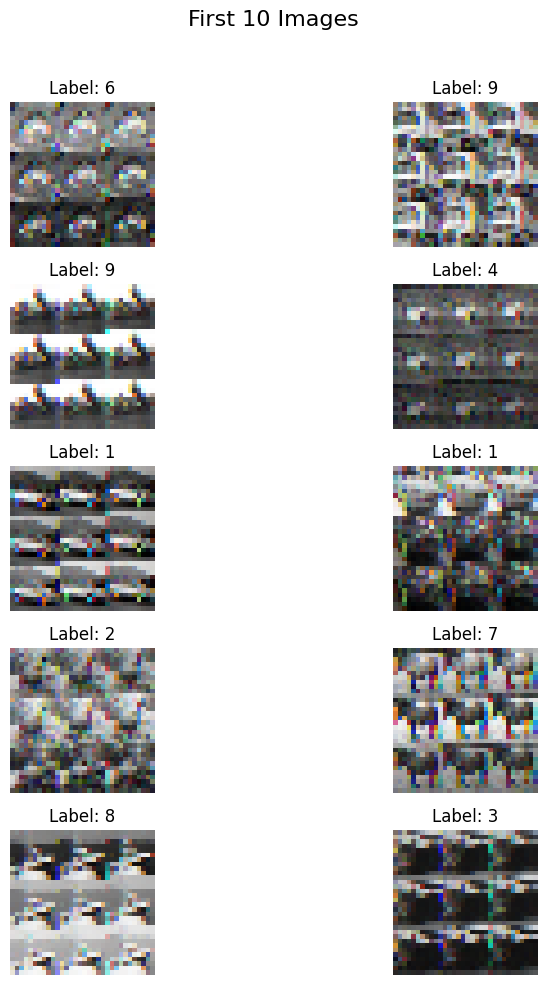

In [ ]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
fig.suptitle("First 10 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 0:3072].values.reshape(32,32,3)  # Reshape to
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, -1]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [ ]:
# train test data

X = df.iloc[:, 0:3072].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10 statistics
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [ ]:
class CustomDataset(Dataset):
    def __init__ (self,features,targets,transform=None):
      self.features = torch.tensor(features,dtype=torch.float32).reshape(-1, 3, 32, 32)
      self.targets=torch.tensor(targets,dtype=torch.long)
      self.transform = transform


    def __len__(self):
      return self.features.shape[0]

    def __getitem__(self,idx):
      return self.features[idx],self.targets[idx]

In [ ]:
train_dataset = CustomDataset(X_train, y_train,train_transform)
test_dataset = CustomDataset(X_test, y_test,test_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32 ,shuffle=False, pin_memory=True)
batch_size=32

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, Number_of_classes):
        super().__init__()
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, Number_of_classes)
        )
    def forward(self,x):
        x=self.features(x)
        x=self.classifier(x)
        return x




In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
learning_rate=0.01
epochs=100

In [ ]:

#from torchinfo import summary
model=ConvNet(Number_of_classes=10).to(device)
#print(summary(model, input_size=(batch_size, 3, 32, 32)))
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)


In [ ]:
# training loop
for epoch in range(epochs):

  total_epoch_loss=0
  for batch_features, batch_labels in train_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)

    outputs=model(batch_features)
    loss=criterion(outputs,batch_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_epoch_loss += loss.item()

  avg_loss=total_epoch_loss/len(train_loader)
  print(f"Epoch: {epoch+1},Loss: {avg_loss}")




Epoch: 1,Loss: 1.8484831314086914
Epoch: 2,Loss: 1.5759000670433045
Epoch: 3,Loss: 1.4659240983486175
Epoch: 4,Loss: 1.4046440866470338


KeyboardInterrupt: 

In [ ]:
model.eval()

In [ ]:
# evaluation of train set
total=0
correct=0

with torch.no_grad():
  for batch_features,batch_labels in train_loader:

    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    outputs=model(batch_features)
    _,predicted=torch.max(outputs,1)
    total+= batch_labels.shape[0]
    correct=correct+(predicted==batch_labels).sum().item()
  print((correct/total)*100,' %')

In [ ]:
# evaluation of test set
total=0
correct=0

with torch.no_grad():
  for batch_features,batch_labels in test_loader:

    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    outputs=model(batch_features)
    _,predicted=torch.max(outputs,1)
    total+= batch_labels.shape[0]
    correct=correct+(predicted==batch_labels).sum().item()
  print((correct/total)*100,' %')